In [ ]:
%pylab inline
!pip install -q librosa

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/")

In [ ]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

**MNIST Dataset**

In [ ]:
# include any other imports that you want

'''
This file contains a class for you to implement your neural net.
Basic function skeleton is given, and some comments to guide you are also there.

You will find it convenient to look at the tensorflow API to understand what functions to use.
'''

'''
Implement the respective functions in this class
You might also make separate classes for separate tasks , or for separate kinds of networks (normal feed-forward / CNNs)
'''
class myNeuralNet:
	# you can add/modify arguments of *ALL* functions
	# you might also add new functions, but *NOT* remove these ones
  def __init__(self, dim_input_data, dim_output_data): # you can add/modify arguments of this function 
		# Using such 'self-ization', you can access these members in later functions of the class
		# You can do such 'self-ization' on tensors also, there is no change
    self.dim_input_data = dim_input_data
    self.dim_output_data = dim_output_data
    self.in_dim_for_next_layer=dim_input_data
    self.num_layers = 0
		# Create placeholders for input : data as well as labels
		# You might want to initialising some container to store all the layers of the network
    self.trainX=tf.placeholder(tf.float32, [None, dim_input_data], name="input_features")
    self.trainY=tf.placeholder(tf.float32, [None, dim_output_data], name="output_labels")
    self.weights={}
    self.biases={}
    self.regularizer=0
    self.y={}
    
  def addHiddenLayer(self, layer_dim, activation_fn=None, regularizer_fn=None, regularizer_wgt=0):
		# Add a layer to the network of layer_dim
		# It might be a good idea to append the new layer to the container of layers that you initialized before
    
    self.num_layers += 1
    
    self.weights['h'+str(self.num_layers)] = tf.Variable(tf.truncated_normal([self.in_dim_for_next_layer, layer_dim], mean=0, stddev=1 / np.sqrt(self.in_dim_for_next_layer)))
    self.biases['b'+str(self.num_layers)] = tf.Variable(tf.truncated_normal([layer_dim],mean=0, stddev=1 / np.sqrt(self.in_dim_for_next_layer)))
    if regularizer_fn != None:
      self.regularizer += regularizer_wgt*regularizer_fn(self.weights['h'+str(self.num_layers)])
    if self.num_layers == 1:
      self.y['y'+str(self.num_layers)] = activation_fn(tf.matmul(self.trainX, self.weights['h' + str(self.num_layers)]) + self.biases['b'+str(self.num_layers)])
    else:
      self.y['y'+str(self.num_layers)] = activation_fn(tf.matmul(self.y['y'+str(self.num_layers - 1)], self.weights['h' + str(self.num_layers)]) + self.biases['b'+str(self.num_layers)])
    
    self.in_dim_for_next_layer = layer_dim

  def addFinalLayer(self, activation_fn=None, regularizer_fn=None, regularizer_wgt=0):
		# We don't take layer_dim here, since the dimensionality of final layer is
		# already stored in self.dim_output_data
    # Create the output of the final layer as logits
		# You might also like to apply the final activation function (softmax / sigmoid) to get the predicted labels
    
    self.weights['out'] = tf.Variable(tf.truncated_normal([self.in_dim_for_next_layer, self.dim_output_data], mean=0, stddev=1 / np.sqrt(self.in_dim_for_next_layer)))
    self.biases['out'] = tf.Variable(tf.truncated_normal([self.dim_output_data],mean=0, stddev=1 / np.sqrt(self.in_dim_for_next_layer)))
    if regularizer_fn != None:
      self.regularizer += regularizer_wgt*regularizer_fn(self.weights['h'+str(self.num_layers)])
    if activation_fn == None:
      self.predictions = tf.matmul(self.y['y'+str(self.num_layers)], self.weights['out']) + self.biases['out']
    else:
      self.predictions = activation_fn(tf.matmul(self.y['y'+str(self.num_layers)], self.weights['out']) + self.biases['out'])
		
  def setup_training(self, learn_rate):
		# Define loss, you might want to store it as self.loss
		# Define the train step as self.train_step = ..., use an optimizer from tf.train and call minimize(self.loss)
    
    self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.predictions, labels = self.trainY)) + self.regularizer 
    self.train_step = tf.train.AdamOptimizer(learn_rate).minimize(self.loss)
		
  def setup_metrics(self):
		# Use the predicted labels and compare them with the input labels(placeholder defined in __init__)
		# to calculate accuracy, and store it as self.accuracy
		
    self.correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.trainY, 1))
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32), name="Accuracy")
    
  def setup_training_speech(self, learn_rate):
    self.loss = tf.losses.mean_squared_error(labels=self.trainY, predictions=self.predictions) + + self.regularizer
    self.train_step = tf.train.AdamOptimizer(learn_rate).minimize(self.loss)
                               
  def setup_metrics_speech(self):                         
    self.correct_prediction = tf.equal(tf.math.round(self.predictions), self.trainY)
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32), name="Accuracy")
	
	# you will need to add other arguments to this function as given below
  def train(self, sess, max_epochs, batch_size, train_size, train_x, train_y, valid_x, valid_y, test_x, print_step = 100): # valid_size, test_size, etc
		# Write your training part here
		# sess is a tensorflow session, used to run the computation graph
		# note that all the functions uptil now were just constructing the computation graph
		
		# one 'epoch' represents that the network has seen the entire dataset once - it is just standard terminology
    steps_per_epoch = int(train_size/batch_size)
    max_steps = max_epochs * steps_per_epoch
    train_losses=[]
    valid_losses=[]
    valid_accuracies=[]
    valid_steps=[]
    for step in range(max_steps):
			# read a batch of data from the training data
      
      offset = (step * batch_size) % (train_size - batch_size)
      batch_data = train_x[offset:(offset + batch_size), :]
      batch_labels = train_y[offset:(offset + batch_size), :]
      
			# now run the train_step, self.loss on this batch of training data. something like :
      _, train_loss = sess.run([self.train_step, self.loss], feed_dict={self.trainX: batch_data, self.trainY: batch_labels})
      
      if (step % print_step) == 0 or step == max_steps-1:
				# read the validation dataset and report loss, accuracy on it by running
        
        val_acc, val_loss = sess.run([self.accuracy, self.loss], feed_dict={self.trainX: valid_x, self.trainY: valid_y})
        print("Step: ", step, " Training_Loss: ", train_loss, " Val_Loss: ", val_loss, " Val_Acc: ", val_acc)
				# remember that the above will give you val_acc, val_loss as numpy values and not tensors
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)
        valid_steps.append(step)
			# store these train_loss and validation_loss in lists/arrays, write code to plot them vs steps
      
			# Above curves are *REALLY* important, they give deep insights on what's going on
		# -- for loop ends --
    
    #Plotting Graphs
    plt.title("Training/Validation Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.plot(valid_steps, valid_losses, label="Validation Loss")
    plt.plot(valid_steps, train_losses, label="Training Loss")
    plt.legend(loc=0)
    plt.show()
    
    plt.title("Validation Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.plot(valid_steps, valid_accuracies)
    plt.show()
    
		# Now once training is done, run predictions on the test set
		#test_predictions = sess.run('''here, put something like self.predictions that you would have made somewhere''', feed_dict={'''here, feed in test dataset'''})
		#return test_predictions
    test_prediction = sess.run(self.predictions, feed_dict={self.trainX: test_x})
    test_prediction = np.array(test_prediction).argmax(axis = 1)
    return test_prediction
		# This is because we will ask you to submit test_predictions, and some marks will be based on how your net performs on these unseen instances (test set)
    
  def train_speech(self, sess, max_epochs, batch_size, train_size, train_x, train_y, valid_x, valid_y, test_x, print_step = 100): # valid_size, test_size, etc
		# Write your training part here
		# sess is a tensorflow session, used to run the computation graph
		# note that all the functions uptil now were just constructing the computation graph
		
		# one 'epoch' represents that the network has seen the entire dataset once - it is just standard terminology
    steps_per_epoch = int(train_size/batch_size)
    max_steps = max_epochs * steps_per_epoch
    train_losses=[]
    valid_losses=[]
    valid_accuracies=[]
    valid_steps=[]
    for step in range(max_steps):
			# read a batch of data from the training data
      
      offset = (step * batch_size) % (train_size - batch_size)
      batch_data = train_x[offset:(offset + batch_size), :]
      batch_labels = train_y[offset:(offset + batch_size), :]
      
			# now run the train_step, self.loss on this batch of training data. something like :
      _, train_loss = sess.run([self.train_step, self.loss], feed_dict={self.trainX: batch_data, self.trainY: batch_labels})
      
      if (step % print_step) == 0 or step == max_steps-1:
				# read the validation dataset and report loss, accuracy on it by running
        
        val_acc, val_loss = sess.run([self.accuracy, self.loss], feed_dict={self.trainX: valid_x, self.trainY: valid_y})
        print("Step: ", step, " Training_Loss: ", train_loss, " Val_Loss: ", val_loss, " Val_Acc: ", val_acc)
				# remember that the above will give you val_acc, val_loss as numpy values and not tensors
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)
        valid_steps.append(step)
			# store these train_loss and validation_loss in lists/arrays, write code to plot them vs steps
      
			# Above curves are *REALLY* important, they give deep insights on what's going on
		# -- for loop ends --
    
    #Plotting Graphs
    plt.title("Training/Validation Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.plot(valid_steps, valid_losses, label="Validation Loss")
    plt.plot(valid_steps, train_losses, label="Training Loss")
    plt.legend(loc=0)
    plt.show()
    
    plt.title("Validation Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.plot(valid_steps, valid_accuracies)
    plt.show()
    
		# Now once training is done, run predictions on the test set
		#test_predictions = sess.run('''here, put something like self.predictions that you would have made somewhere''', feed_dict={'''here, feed in test dataset'''})
		#return test_predictions
    test_prediction = sess.run(self.predictions, feed_dict={self.trainX: test_x})
    test_prediction = np.round(np.array(test_prediction))
    return test_prediction
    '''
	  We have done everything in train(), but
		you might want to create another function named eval(),
		which calculates the predictions on test instances ...
    '''
    
  '''
	NOTE:
	you might find it convenient to make 3 different train functions corresponding to the three different tasks,
	and call the relevant one from each train_*.py
	The reason for this is that the arguments to the train() are different across the tasks
  '''
  '''
	Example, for the speech part, the train() would look something like :
	(NOTE: this is only a rough structure, we don't claim that this is exactly what you have to do.)
	'''

'\n  def train(self, sess, batch_size, train_size, max_epochs, train_signal, train_lbls, valid_signal, valid_lbls, test_signal, print_step = 100):\n    steps_per_epoch = math.ceil(train_size/batch_size)\n    max_steps = max_epochs*steps_per_epoch\n    print(max_steps)\n    for step in range(max_steps):\n\t\t\t# select batch_size elements randomly from training data\n      sampled_indices = np.random.choice(range(train_size), batch_size)\n      trn_signal = train_signal[sampled_indices]\n      trn_labels = train_lbls[sampled_indices]\n      _, train_loss = sess.run([self.train_step, self.loss], feed_dict={self.trainX: trn_signal, self.trainY: trn_labels})\n      if (step % print_step) == 0:\n        val_loss, val_acc = sess.run([self.loss, self.accuracy], feed_dict={self.trainX: valid_signal, self.trainY: valid_lbls})\n        print("Step: ", step, " Training_Loss: ", train_loss, " Val_Loss: ", val_loss, " Val_Acc: ", val_acc)\n    \n    test_prediction = sess.run([self.predictions], fe

Step:  0  Training_Loss:  2.3023112  Val_Loss:  2.3002627  Val_Acc:  0.1115234
Step:  500  Training_Loss:  1.6114502  Val_Loss:  1.5455846  Val_Acc:  0.9276438
Step:  1000  Training_Loss:  1.4917096  Val_Loss:  1.5384961  Val_Acc:  0.9286745
Step:  1500  Training_Loss:  1.5285094  Val_Loss:  1.5144187  Val_Acc:  0.9503195
Step:  2000  Training_Loss:  1.5019716  Val_Loss:  1.5090489  Val_Acc:  0.9562977
Step:  2500  Training_Loss:  1.4923712  Val_Loss:  1.5035111  Val_Acc:  0.959596
Step:  3000  Training_Loss:  1.4971515  Val_Loss:  1.5133696  Val_Acc:  0.9521748
Step:  3500  Training_Loss:  1.5173895  Val_Loss:  1.5027469  Val_Acc:  0.9612451
Step:  4000  Training_Loss:  1.5491045  Val_Loss:  1.4997644  Val_Acc:  0.96371883
Step:  4500  Training_Loss:  1.4625831  Val_Loss:  1.4965649  Val_Acc:  0.96619254
Step:  5000  Training_Loss:  1.5097011  Val_Loss:  1.4957062  Val_Acc:  0.96681094
Step:  5500  Training_Loss:  1.4836715  Val_Loss:  1.4924188  Val_Acc:  0.9692847
Step:  6000  Train

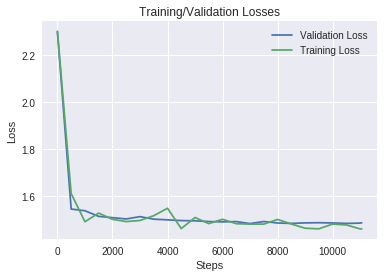

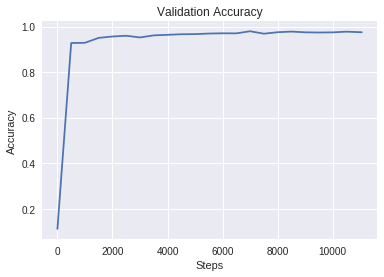

In [ ]:
xtrain = np.load('/content/drive/My Drive/asgn3/data/mnist/xtrain.npy')
ytrain = np.load('/content/drive/My Drive/asgn3/data/mnist/ytrain.npy')

xval = np.load('/content/drive/My Drive/asgn3/data/mnist/xval.npy')
yval = np.load('/content/drive/My Drive/asgn3/data/mnist/yval.npy')

xtest = np.load('/content/drive/My Drive/asgn3/data/mnist/xtest.npy')

dim_input = 784
dim_output = 10

max_epochs = 10
learn_rate = 1e-4
batch_size = 50

train_size = len(xtrain)
valid_size = len(xval)
test_size = len(xtest)

total_images = []
total_labels = []

# Create Computation Graph
nn_instance = myNeuralNet(dim_input, dim_output)
nn_instance.addHiddenLayer(2048, activation_fn=tf.nn.relu)
nn_instance.addHiddenLayer(1024, activation_fn=tf.nn.relu)
nn_instance.addHiddenLayer(512, activation_fn=tf.nn.relu)
# add more hidden layers here by calling addHiddenLayer as much as you want
# a net of depth 3 should be sufficient for most tasks
nn_instance.addFinalLayer(activation_fn = tf.nn.softmax)
nn_instance.setup_training(learn_rate)
nn_instance.setup_metrics()

# Training steps
with tf.Session() as sess:
	sess.run(tf.global_variables_initializer())
	test_pred = nn_instance.train(sess, max_epochs, batch_size, train_size, xtrain, ytrain, xval, yval, xtest, print_step = 500)

In [ ]:
np.save("predictions_mnist",test_pred)

2 Hidden Layers 1024 and 512: Val_acc = 0.9760874
3 Hidden Layers 1024, 512, and 256: Val_acc = 0.97237

**Speech Dataset**

In [ ]:
import librosa
#Defining properties
dim_input = 900
dim_output = 1

# strings for file reading
train_fname = '/content/drive/My Drive/asgn3/data/speech/train/flist.txt'
val_fname = '/content/drive/My Drive/asgn3/data/speech/validation/flist.txt'
test_fname = '/content/drive/My Drive/asgn3/data/speech/test/flist.txt'

''' util function for reading'''
# count_go = 0
# count_stop = 0
def interpretLine(line, append_str):
	global count_go, count_stop
	cleanLine = line.strip()
	fileName = append_str + cleanLine
	if 'go_' in cleanLine:
		label = 1.0
		# count_go += 1
	else:
		label = 0.0
		# count_stop += 1        
	return fileName, label

''' util function for speech sampling'''
def sample(fpath):
	signal,_ = librosa.load(fpath)
	signal = librosa.feature.mfcc(y=signal, n_mfcc=int(dim_input/45))
	# print("after mfcc:", signal.shape)
	signal = signal.flatten()
	signal = np.resize(signal, new_shape=(dim_input,1))
	return np.transpose(signal)


In [ ]:
# Import data
# storing train data
train_input = [] # list of strings - each entry is a filepath
train_labels = [] # list of labels - each entry is a float
with open(train_fname) as f:
	append_str = '/content/drive/My Drive/asgn3/data/speech/train/'
	for line in f:
		fileName, label = interpretLine(line, append_str)
		train_input.append(fileName)
		train_labels.append(label)

# storing validation data - similar
valid_input = []
valid_labels = []
with open(val_fname) as f:
	append_str = '/content/drive/My Drive/asgn3/data/speech/validation/'
	for line in f:
		fileName, label = interpretLine(line, append_str)
		valid_input.append(fileName)
		valid_labels.append(label)

# storing test data
test_input = []
# remember you don't have test labels
with open(test_fname) as f:
	append_str = '/content/drive/My Drive/asgn3/data/speech/test/'
	for line in f:
		fileName = append_str + line.strip()
		test_input.append(fileName)

train_size = len(train_input)
valid_size = len(valid_input)
test_size = len(test_input)






In [ ]:
test_size

899

In [ ]:

''' Create arrays for training, validation, test '''

# read and store mfcc for training set
train_signal = np.empty(shape=(train_size, dim_input))
train_lbls = np.empty(shape=(train_size, dim_output))
# this will take a lot of time
for index_train in range(train_size):
	train_signal[index_train] = sample(train_input[index_train])
	train_lbls[index_train] = np.transpose( np.reshape(np.array(train_labels[index_train]), newshape=(dim_output,1) ) )
	if index_train%100 == 0:
		print("Read ", index_train, " instances out of full train set.")
print("Read full training set.")
# print(count_go)
# print(count_stop)
        
# print(train_signal.shape)
# print(train_lbls.shape)

# print(train_signal[0])
# print(train_lbls[0])


Read  0  instances out of full train set.
Read  100  instances out of full train set.
Read  200  instances out of full train set.
Read  300  instances out of full train set.
Read  500  instances out of full train set.
Read  600  instances out of full train set.
Read  700  instances out of full train set.
Read  800  instances out of full train set.
Read  900  instances out of full train set.
Read  1000  instances out of full train set.
Read  1100  instances out of full train set.
Read  1200  instances out of full train set.
Read  1300  instances out of full train set.
Read  1400  instances out of full train set.
Read  1500  instances out of full train set.
Read  1600  instances out of full train set.
Read  1700  instances out of full train set.
Read  1800  instances out of full train set.
Read  1900  instances out of full train set.
Read  2000  instances out of full train set.
Read  2100  instances out of full train set.
Read  2200  instances out of full train set.
Read  2300  instances

In [ ]:
np.save("speech_training_attr.npy", train_signal)
np.save("speech_training_label.npy", train_lbls)

In [ ]:
# read and store mfcc for validation set
valid_signal = np.empty(shape=(valid_size, dim_input))
valid_lbls = np.empty(shape=(valid_size, dim_output))
for index_valid in range(valid_size):
	valid_signal[index_valid] = sample(valid_input[index_valid])
	valid_lbls[index_valid] = np.transpose( np.reshape(np.array(valid_labels[index_valid]), newshape=(dim_output,1) ) )
	if index_valid%100 == 0:
		print("Read ", index_valid, " instances out of full validation set.")
print("Read full validation set.")

# read and store mfcc for test set (only signals here, no labels)
test_signal = np.empty(shape=(test_size, dim_input))
for index_test in range(test_size):
	test_signal[index_test] = sample(test_input[index_test])
	if index_test%100 == 0:
		print("Read ", index_test, " instances out of full test set.")
print("Read full test set.")

Read  0  instances out of full validation set.
Read  100  instances out of full validation set.
Read  200  instances out of full validation set.
Read  300  instances out of full validation set.
Read  400  instances out of full validation set.
Read full validation set.
Read  0  instances out of full test set.
Read  100  instances out of full test set.
Read  300  instances out of full test set.
Read  400  instances out of full test set.
Read  500  instances out of full test set.
Read  600  instances out of full test set.
Read  700  instances out of full test set.
Read  800  instances out of full test set.
Read full test set.


In [ ]:
np.save("speech_valid_attr.npy", valid_signal)
np.save("speech_valid_label.npy", valid_lbls)

np.save("speech_test_attr.npy", test_signal)

In [ ]:
train_signal = np.load('drive/My Drive/asgn3/data/speech/speech_training_attr.npy')
train_lbls = np.load('drive/My Drive/asgn3/data/speech/speech_training_label.npy')

valid_signal = np.load('drive/My Drive/asgn3/data/speech/speech_valid_attr.npy')
valid_lbls = np.load('drive/My Drive/asgn3/data/speech/speech_valid_label.npy')

test_signal = np.load('drive/My Drive/asgn3/data/speech/speech_test_attr.npy')

Step:  0  Training_Loss:  0.4762786  Val_Loss:  0.54590166  Val_Acc:  0.42222223
Step:  500  Training_Loss:  0.28700092  Val_Loss:  0.29780522  Val_Acc:  0.67333335
Step:  1000  Training_Loss:  0.07630714  Val_Loss:  0.10745158  Val_Acc:  0.88
Step:  1500  Training_Loss:  0.052132323  Val_Loss:  0.11769473  Val_Acc:  0.8577778
Step:  2000  Training_Loss:  0.04798583  Val_Loss:  0.095198736  Val_Acc:  0.8977778
Step:  2500  Training_Loss:  0.04011582  Val_Loss:  0.08718895  Val_Acc:  0.9022222
Step:  3000  Training_Loss:  0.06043828  Val_Loss:  0.08133384  Val_Acc:  0.9022222
Step:  3500  Training_Loss:  0.040273048  Val_Loss:  0.08235016  Val_Acc:  0.9
Step:  4000  Training_Loss:  0.002120501  Val_Loss:  0.08348359  Val_Acc:  0.89111114
Step:  4500  Training_Loss:  6.420903e-05  Val_Loss:  0.07563165  Val_Acc:  0.9088889
Step:  5000  Training_Loss:  0.020034714  Val_Loss:  0.0770792  Val_Acc:  0.9111111
Step:  5500  Training_Loss:  0.013271618  Val_Loss:  0.07362449  Val_Acc:  0.915555

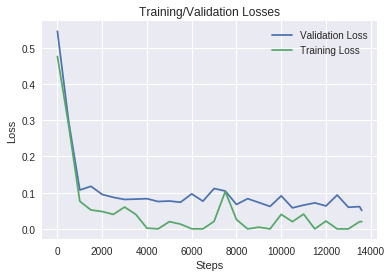

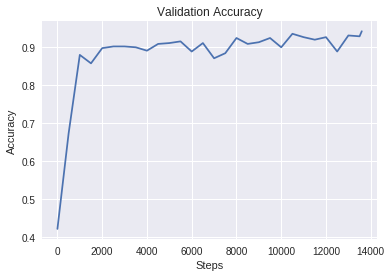

In [ ]:
max_epochs = 200
learn_rate = 2e-6
batch_size = 50

# Create Computation Graph
nn_instance = myNeuralNet(dim_input, dim_output)
nn_instance.addHiddenLayer(4096, activation_fn=tf.nn.relu)
nn_instance.addHiddenLayer(2048, activation_fn=tf.nn.relu)
nn_instance.addHiddenLayer(1024, activation_fn=tf.nn.relu)
# add more hidden layers here by calling addHiddenLayer as much as you want
# a net of depth 3 should be sufficient for most tasks
nn_instance.addFinalLayer(tf.nn.sigmoid)
nn_instance.setup_training_speech(learn_rate)
nn_instance.setup_metrics_speech()

# Training steps
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  test_pred= nn_instance.train_speech(sess, max_epochs, batch_size, train_size, train_signal, train_lbls, valid_signal, valid_lbls, test_signal, print_step = 500) # add more arguments here
 

Val_Acc: 0.9444444

In [ ]:
# np.savetxt("predictions_speech.txt", test_pred, fmt="%u")
file = open("predictions_speech.txt","w")
for i in range(test_pred.shape[0]):
  if test_pred[i] == 0:
    file.write("stop\n")
  elif test_pred[i] == 1:
    file.write("go\n")
    
file.close()

**Census Dataset**

In [ ]:
dim_input = 105 # change this according to your encoding of the input features
dim_output = 2 # binary class classification can be done using sigmoid

max_epochs = 50
learn_rate = 1e-4
batch_size = 50

def file_size(fname):
	with open(fname) as f:
		for i, l in enumerate(f):
			pass
	return i + 1

train_fname = '/content/drive/My Drive/asgn3/data/census/train_data'
valid_fname = '/content/drive/My Drive/asgn3/data/census/validation_data'
test_fname = '/content/drive/My Drive/asgn3/data/census/test_data'
train_size = file_size(train_fname)
valid_size = file_size(valid_fname)
test_size = file_size(test_fname)

print(train_size)
print(valid_size)
print(test_size)




34190
4884
9768


In [ ]:
import pandas as pd

def file_to_df(fname, df):
  with open(fname, "r") as file:
    for i,line in enumerate(file):
      if(i%1000 == 0):
        print(i)
      currentline = line.rstrip(".\n").split(",")
      df.loc[i] = currentline
  return df

def clean_df(df, categorical_cols):
  df.replace(" ?",np.nan)
  cts_cols = list(set(df.columns.values) - set(categorical_cols))
  for col in categorical_cols:
    df[col].fillna(df[col].mode()[0])
  for col in cts_cols:
    df = df.astype({col: float})
    df[col].fillna(round(df[col].astype(float).mean()))
  return df


In [ ]:
column_names=["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","class"]
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

train_df=pd.DataFrame(columns = column_names)
train_df = file_to_df(train_fname, train_df)
print("File -> Dataframe successful")  

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
File -> Dataframe successful


In [ ]:
train_df.to_pickle("census_train_raw")

In [ ]:
train_df = pd.read_pickle("census_train_raw")
print(train_df.loc[0])

age                                28
worldclass                    Private
fnlwgt                         189530
education                     HS-grad
education-num                       9
marital-status     Married-civ-spouse
occupation                      Sales
relationship                  Husband
race                            White
sex                              Male
capital-gain                        0
capital-loss                        0
hours-per-week                     35
native-country          United-States
class                           <=50K
Name: 0, dtype: object


In [ ]:
train_df["age"].astype(float).mean()

38.64068441064639

In [ ]:
trainX = train_df.iloc[:,:-1]
trainY = train_df.iloc[:,-1]

trainX = clean_df(trainX, categorical_cols)
print(trainX.head())
print(trainY.head())

    age         worldclass    fnlwgt      education  education-num  \
0  28.0            Private  189530.0        HS-grad            9.0   
1  31.0            Private  131633.0        HS-grad            9.0   
2  34.0            Private  535869.0   Some-college           10.0   
3  42.0   Self-emp-not-inc  175674.0        HS-grad            9.0   
4  51.0          Local-gov  250054.0   Some-college           10.0   

        marital-status      occupation    relationship    race      sex  \
0   Married-civ-spouse           Sales         Husband   White     Male   
1   Married-civ-spouse    Craft-repair         Husband   White     Male   
2        Never-married   Other-service   Not-in-family   Black     Male   
3   Married-civ-spouse           Sales         Husband   White     Male   
4              Widowed   Other-service       Unmarried   White   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0           0.0           0.0            35.0   United-States  


In [ ]:
column_names=["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","class"]
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

attr_dict = {
    'workclass': [' Private', ' Self-emp-not-inc', ' Self-emp-inc', ' Federal-gov', ' Local-gov', ' State-gov', ' Without-pay', ' Never-worked'],
    'education': [' Bachelors', ' Some-college', ' 11th', ' HS-grad', ' Prof-school', ' Assoc-acdm', ' Assoc-voc', ' 9th', ' 7th-8th', ' 12th', ' Masters', ' 1st-4th', ' 10th', ' Doctorate', ' 5th-6th', ' Preschool'],
    'marital-status': [' Married-civ-spouse', ' Divorced', ' Never-married', ' Separated', ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse'],
    'occupation': [' Tech-support', ' Craft-repair', ' Other-service', ' Sales', ' Exec-managerial', ' Prof-specialty', ' Handlers-cleaners', ' Machine-op-inspct', ' Adm-clerical', ' Farming-fishing', ' Transport-moving', ' Priv-house-serv', ' Protective-serv', ' Armed-Forces'],
    'relationship': [' Wife', ' Own-child', ' Husband', ' Not-in-family', ' Other-relative', ' Unmarried'],
    'race': [' White', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other', ' Black'],
    'sex': [' Female', ' Male'],
    'native-country': [' United-States', ' Cambodia', ' England', ' Puerto-Rico', ' Canada', ' Germany', ' Outlying-US(Guam-USVI-etc)', ' India', ' Japan', ' Greece', ' South', ' China', ' Cuba', ' Iran',' Honduras',' Philippines',' Italy',' Poland',' Jamaica',' Vietnam',' Mexico',' Portugal',' Ireland',' France',' Dominican-Republic',' Laos',' Ecuador',' Taiwan',' Haiti',' Columbia', ' Hungary', ' Guatemala', ' Nicaragua', ' Scotland', ' Thailand', ' Yugoslavia', ' El-Salvador', ' Trinadad&Tobago', ' Peru', ' Hong', ' Holand-Netherlands']
}

In [ ]:
trainX = trainX.rename(columns = {"worldclass": "workclass"})

In [ ]:
def one_hot_encode(df, categorical_cols, attr_dict):
  cts_cols = list(set(df.columns.values) - set(categorical_cols))
  cts_df = pd.DataFrame(df[cts_cols])
  
  new_attr = []
  for col in categorical_cols:
    new_attr += attr_dict[col]
    
  df_ohe = pd.DataFrame(0, index=np.arange(df.shape[0]), columns = new_attr)
  for col in categorical_cols:
    for i in range(df.shape[0]):
      df_ohe.iloc[i][df.iloc[i][col]] = 1
      
  df_ohe = pd.concat([cts_df, df_ohe], axis=1)
  return df_ohe.values

In [ ]:
trainX_ohe = one_hot_encode(trainX, categorical_cols, attr_dict)
print(trainX_ohe.shape)

(34190, 105)


In [ ]:
np.save("census_trainX_encoded", trainX_ohe)

In [ ]:
def encode_labels(series, encoded_col_names):
  df_encoded = pd.DataFrame(0, index=np.arange(series.shape[0]), columns = encoded_col_names)
  for i in range(series.shape[0]):
    df_encoded.iloc[i][series[i]] = 1
    
  return df_encoded.values


trainY_e = encode_labels(trainY, [' <=50K',' >50K'])
print(trainY_e.shape)

(34190, 2)


In [ ]:
valid_df=pd.DataFrame(columns = column_names)
valid_df = file_to_df(valid_fname, valid_df)
print("File -> Dataframe successful")  

0
1000
2000
3000
4000
File -> Dataframe successful


In [ ]:
validX = valid_df.iloc[:,:-1]
validY = valid_df.iloc[:,-1]

validX = clean_df(validX, categorical_cols)

validX_ohe = one_hot_encode(validX, categorical_cols, attr_dict)
print(validX_ohe.shape)
validY_e = encode_labels(validY, [' <=50K',' >50K'])
print(validY_e.shape)

(4884, 105)
(4884, 2)


In [ ]:
test_df=pd.DataFrame(columns = column_names)
test_df = file_to_df(test_fname, test_df)
# print("File -> Dataframe successful")  
testX = test_df.iloc[:,:-1]
testX = clean_df(testX, categorical_cols)
testX_ohe = one_hot_encode(testX, categorical_cols, attr_dict)
# print(testX_ohe.shape)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
File -> Dataframe successful
(9768, 105)


In [ ]:
np.save("census_trainY_encoded", trainY_e)
np.save("census_validY_encoded", validY_e)

In [ ]:
trainX_ohe = np.load("drive/My Drive/asgn3/data/census/census_trainX_encoded.npy")
trainY_e = np.load("drive/My Drive/asgn3/data/census/census_trainY_encoded.npy")

validX_ohe = np.load("drive/My Drive/asgn3/data/census/census_validX_encoded.npy")
validY_e = np.load("drive/My Drive/asgn3/data/census/census_validY_encoded.npy")

testX_ohe = np.load("drive/My Drive/asgn3/data/census/census_testX_encoded.npy")

Step:  0  Training_Loss:  8.9068775  Val_Loss:  8.492095  Val_Acc:  0.24447174
Step:  500  Training_Loss:  5.9748635  Val_Loss:  5.921791  Val_Acc:  0.79095006
Step:  1000  Training_Loss:  4.8297067  Val_Loss:  4.82841  Val_Acc:  0.79095006
Step:  1500  Training_Loss:  4.0010643  Val_Loss:  3.99517  Val_Acc:  0.791769
Step:  2000  Training_Loss:  3.358765  Val_Loss:  3.3772624  Val_Acc:  0.7903358
Step:  2500  Training_Loss:  3.0005186  Val_Loss:  2.8873785  Val_Acc:  0.79463553
Step:  3000  Training_Loss:  2.49367  Val_Loss:  2.4991086  Val_Acc:  0.7956593
Step:  3500  Training_Loss:  2.184835  Val_Loss:  2.18611  Val_Acc:  0.79361176
Step:  4000  Training_Loss:  1.9237235  Val_Loss:  1.9259458  Val_Acc:  0.7940213
Step:  4500  Training_Loss:  1.6444868  Val_Loss:  1.7193025  Val_Acc:  0.7923833
Step:  5000  Training_Loss:  1.5863786  Val_Loss:  1.5333651  Val_Acc:  0.79197377
Step:  5500  Training_Loss:  1.5296702  Val_Loss:  1.4000582  Val_Acc:  0.7889025
Step:  6000  Training_Loss:

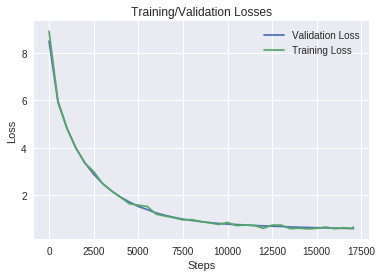

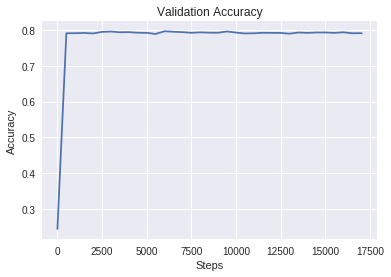

In [ ]:
dim_input = 105 # change this according to your encoding of the input features
dim_output = 2 # binary class classification can be done using sigmoid

max_epochs = 50
learn_rate = 2e-5
batch_size = 100

train_size = trainX_ohe.shape[0]
# Create Computation Graph
nn_instance = myNeuralNet(dim_input, dim_output)
nn_instance.addHiddenLayer(1024, activation_fn=tf.nn.relu6, regularizer_fn = tf.nn.l2_loss, regularizer_wgt=0.01)
nn_instance.addHiddenLayer(512, activation_fn=tf.nn.relu, regularizer_fn = tf.nn.l2_loss, regularizer_wgt=0.01)
nn_instance.addHiddenLayer(256, activation_fn=tf.nn.relu6, regularizer_fn = tf.nn.l2_loss, regularizer_wgt=0.01)
# add more hidden layers here by calling addHiddenLayer as much as you want
# a net of depth 3 should be sufficient for most tasks
nn_instance.addFinalLayer()
nn_instance.setup_training(learn_rate)
nn_instance.setup_metrics()

# Instantiate Session
with tf.Session() as sess:
	sess.run(tf.global_variables_initializer())

	test_pred = nn_instance.train(sess, max_epochs, batch_size, train_size, trainX_ohe, trainY_e, validX_ohe, validY_e, testX_ohe, print_step = 500)

max_epochs = 50<br>
learn_rate = 2e-5<br>
batch_size = 100

L2 reg (wgt:0.01 on all layers)

Training_Loss:   0.66584635  
Val_Loss:  0.6014128  
Val_Acc: 0.791769

1024 ReLU6<br>
512 ReLU<br>
256 ReLU6

In [ ]:
np.savetxt("prediction_census.txt", test_pred, fmt = "%u")

In [ ]:
with open("predictions_census.txt","w") as file:
  for i in range(test_pred.shape[0]):
    if test_pred[i]==0:
      file.write("<=50K\n")
    else:
      file.write(">50K\n")
     

In [ ]:
file = open("predictions_census.txt","r")
print(len(file.readlines()))
file.close()

9768


In [ ]:
class convNet:
  
  def __init__(self, dim_input_data, dim_output_data):
		
    self.dim_input_data = dim_input_data
    self.dim_output_data = dim_output_data
    self.num_layers = 1
    self.layers={}
    self.trainX=tf.placeholder(tf.float32, self.dim_input_data, name="input_features")
    self.trainY=tf.placeholder(tf.float32, [None, dim_output_data], name="output_labels")
    self.curr_layer = self.trainX
  
#   def reshape_input_dim(features, height, width, channels = 1):
#     self.layers['inp_layer'] = tf.reshape(features, [-1, height, width, channels])
#     self.curr_layer = self.layers['inp_layer']
#     self.num_layers+=1
    
    
  def add_conv_layer(self, filters, kernel, padding = "same", activation_fn = None):
    self.layers['conv'+str(self.num_layers)] = tf.layers.conv2d(inputs = self.curr_layer, filters = filters, kernel_size = kernel, padding = padding, activation = activation_fn)
    self.curr_layer = self.layers['conv'+str(self.num_layers)]
    self.num_layers+=1
    
  def add_pooling_layer(self, pool_size, pool_type = tf.layers.max_pooling2d, stride = 1):
    self.layers['pool'+str(self.num_layers)] = pool_type(inputs=self.curr_layer, pool_size=pool_size, strides=stride)
    self.curr_layer = self.layers['pool'+str(self.num_layers)]
    self.num_layers+=1
    
  def add_dense_layer(self, num_units, activation_fn = None):
    self.layers['last_layer_flat'] = tf.reshape(self.curr_layer, [-1, self.curr_layer.shape[1]*self.curr_layer.shape[2]*self.curr_layer.shape[3]])
    self.layers['dense'] = tf.layers.dense(self.layers['last_layer_flat'], units=num_units, activation=activation_fn)
    self.curr_layer = self.layers['dense']
    self.num_layers+=1
    
  def add_final_layer(self, activation_fn = None):
    self.layers['logits'] = tf.layers.dense(inputs=self.curr_layer, units=self.dim_output_data, activation = activation_fn)
    self.predictions = tf.nn.softmax(self.layers['logits'])
    self.num_layers+=1
    
  def setup_training(self, learn_rate):
    self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.predictions, labels = self.trainY))
    self.train_step = tf.train.AdamOptimizer(learn_rate).minimize(self.loss)
		
  def setup_metrics(self):
    self.correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.trainY, 1))
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32), name="Accuracy")
    
  def train(self, sess, max_epochs, batch_size, train_size, train_x, train_y, valid_x, valid_y, test_x, print_step = 100): # valid_size, test_size, etc
    steps_per_epoch = int(train_size/batch_size)
    max_steps = max_epochs * steps_per_epoch
    train_losses=[]
    valid_losses=[]
    valid_accuracies=[]
    valid_steps=[]
    for step in range(max_steps):
      offset = (step * batch_size) % (train_size - batch_size)
      batch_data = train_x[offset:(offset + batch_size), :]
      batch_labels = train_y[offset:(offset + batch_size), :]
      _, train_loss = sess.run([self.train_step, self.loss], feed_dict={self.trainX: batch_data, self.trainY: batch_labels})
      
      if (step % print_step) == 0 or step == max_steps-1:
        val_acc, val_loss = sess.run([self.accuracy, self.loss], feed_dict={self.trainX: valid_x, self.trainY: valid_y})
        print("Step: ", step, " Training_Loss: ", train_loss, " Val_Loss: ", val_loss, " Val_Acc: ", val_acc)
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)
        valid_steps.append(step)
			
    plt.title("Training/Validation Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.plot(valid_steps, valid_losses, label="Validation Loss")
    plt.plot(valid_steps, train_losses, label="Training Loss")
    plt.legend(loc=0)
    plt.show()
    
    plt.title("Validation Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.plot(valid_steps, valid_accuracies)
    plt.show()
    
    test_prediction = sess.run(self.predictions, feed_dict={self.trainX: test_x})
    test_prediction = np.array(test_prediction).argmax(axis = 1)
    return test_prediction

Step:  0  Training_Loss:  2.3025837  Val_Loss:  2.3016875  Val_Acc:  0.15398887
Step:  100  Training_Loss:  1.8317056  Val_Loss:  1.790469  Val_Acc:  0.69470215
Step:  200  Training_Loss:  1.6662866  Val_Loss:  1.7272657  Val_Acc:  0.73840445
Step:  300  Training_Loss:  1.6824509  Val_Loss:  1.6702665  Val_Acc:  0.80643165
Step:  400  Training_Loss:  1.6518115  Val_Loss:  1.6223928  Val_Acc:  0.84374356
Step:  500  Training_Loss:  1.5813518  Val_Loss:  1.5286932  Val_Acc:  0.94166154
Step:  600  Training_Loss:  1.5123254  Val_Loss:  1.5207063  Val_Acc:  0.9459905
Step:  700  Training_Loss:  1.4995767  Val_Loss:  1.5143998  Val_Acc:  0.95196867
Step:  800  Training_Loss:  1.5045981  Val_Loss:  1.5165688  Val_Acc:  0.94949496
Step:  900  Training_Loss:  1.4877472  Val_Loss:  1.5153272  Val_Acc:  0.94990724
Step:  1000  Training_Loss:  1.4905863  Val_Loss:  1.507304  Val_Acc:  0.9573284
Step:  1100  Training_Loss:  1.5280728  Val_Loss:  1.5096858  Val_Acc:  0.9554731
Step:  1200  Training

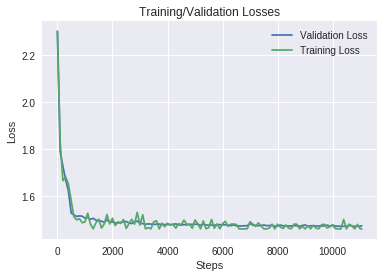

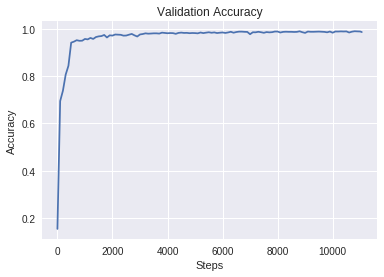

In [ ]:
xtrain = np.load('/content/drive/My Drive/asgn3/data/mnist/xtrain.npy')
xtrain = np.reshape(xtrain, (xtrain.shape[0], 28, 28, 1))
ytrain = np.load('/content/drive/My Drive/asgn3/data/mnist/ytrain.npy')

xval = np.load('/content/drive/My Drive/asgn3/data/mnist/xval.npy')
xval = np.reshape(xval, (xval.shape[0], 28, 28, 1))
yval = np.load('/content/drive/My Drive/asgn3/data/mnist/yval.npy')

xtest = np.load('/content/drive/My Drive/asgn3/data/mnist/xtest.npy')
xtest = np.reshape(xtest, (xtest.shape[0], 28, 28, 1))

dim_input = [None, 28, 28, 1]
dim_output = 10

max_epochs = 10
learn_rate = 1e-4
batch_size = 50

train_size = len(xtrain)
valid_size = len(xval)
test_size = len(xtest)

total_images = []
total_labels = []

# Create Computation Graph
cnn_instance = convNet(dim_input, dim_output)
# cnn_instance.reshape_input_dim(xtrain, 28, 28)
cnn_instance.add_conv_layer(32, 5, "same")
cnn_instance.add_pooling_layer([2,2], tf.layers.max_pooling2d, 2)
cnn_instance.add_conv_layer(64, 5, "same")
cnn_instance.add_pooling_layer([2,2], tf.layers.max_pooling2d, 2)
cnn_instance.add_conv_layer(128, 5, "same", tf.nn.relu)
cnn_instance.add_pooling_layer([2,2], tf.layers.max_pooling2d, 2)
cnn_instance.add_dense_layer(2048, tf.nn.relu)
cnn_instance.add_final_layer()
cnn_instance.setup_training(learn_rate)
cnn_instance.setup_metrics()

# Training steps
with tf.Session() as sess:
	sess.run(tf.global_variables_initializer())
	test_pred = cnn_instance.train(sess, max_epochs, batch_size, train_size, xtrain, ytrain, xval, yval, xtest, print_step = 100)

Training_Loss:  1.4663156<br>
Val_Loss:  1.4756608  <br>
Val_Acc:  0.98557

In [ ]:
test_pred = np.array(test_pred).argmax(axis = 1)

In [ ]:
np.save("predictions_mnist_cnn",test_pred)
